In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, 
                            confusion_matrix, 
                            roc_auc_score,
                            precision_recall_curve,
                            auc)
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import joblib
import warnings
warnings.filterwarnings('ignore')

Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


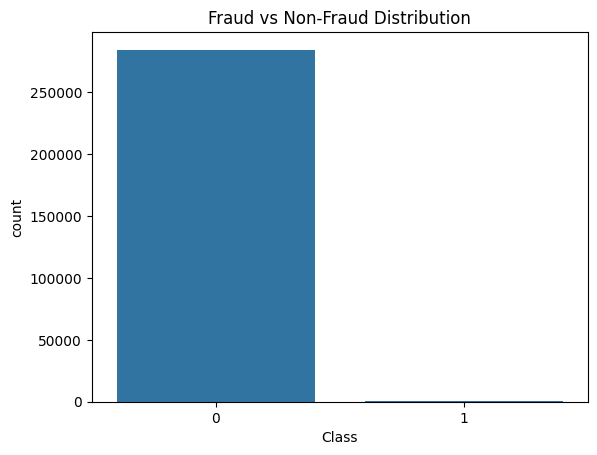

In [4]:
# Load dataset
df = pd.read_csv('creditcard.csv')

# EDA
print("Class Distribution:\n", df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title('Fraud vs Non-Fraud Distribution')
plt.show()

In [5]:
# Preprocessing
X = df.drop('Class', axis=1)
y = df['Class']

# Scale 'Time' and 'Amount'
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                   stratify=y, random_state=42)

In [6]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("\nAfter SMOTE:", pd.Series(y_train_sm).value_counts())


After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [7]:
def build_dnn():
    model = Sequential([
        Dense(32, input_dim=X_train_sm.shape[1], activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [8]:
model = build_dnn()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,217 (20.38 KB)

 Trainable params: 5,217 (20.38 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train with SMOTE
history = model.fit(X_train_sm, y_train_sm,
                    epochs=20,
                    batch_size=2048,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8395 - loss: 0.3271 - val_accuracy: 0.9440 - val_loss: 0.1245
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9660 - loss: 0.0851 - val_accuracy: 0.9798 - val_loss: 0.0585
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9791 - loss: 0.0543 - val_accuracy: 0.9906 - val_loss: 0.0302
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9866 - loss: 0.0355 - val_accuracy: 0.9991 - val_loss: 0.0154
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9913 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 0.0102
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9936 - loss: 0.0206 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9950 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9960 - loss: 0.0138 - val_accuracy: 1.

In [10]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nDNN Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_probs))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step

DNN Performance:
[[56806    58]
 [   15    83]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.59      0.85      0.69        98

    accuracy                           1.00     56962
   macro avg       0.79      0.92      0.85     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9751621843166078


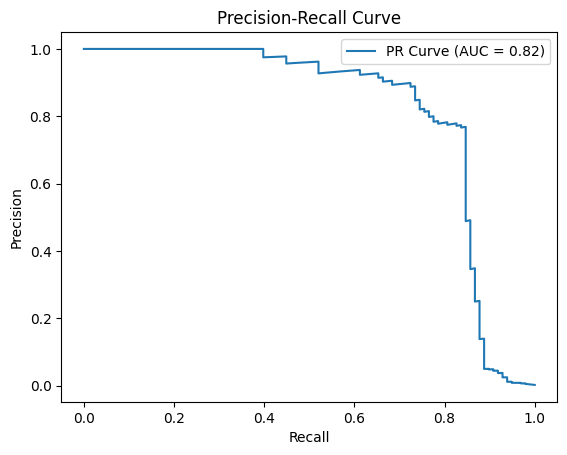

In [11]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
plt.figure()
plt.plot(recall, precision, label=f'PR Curve (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

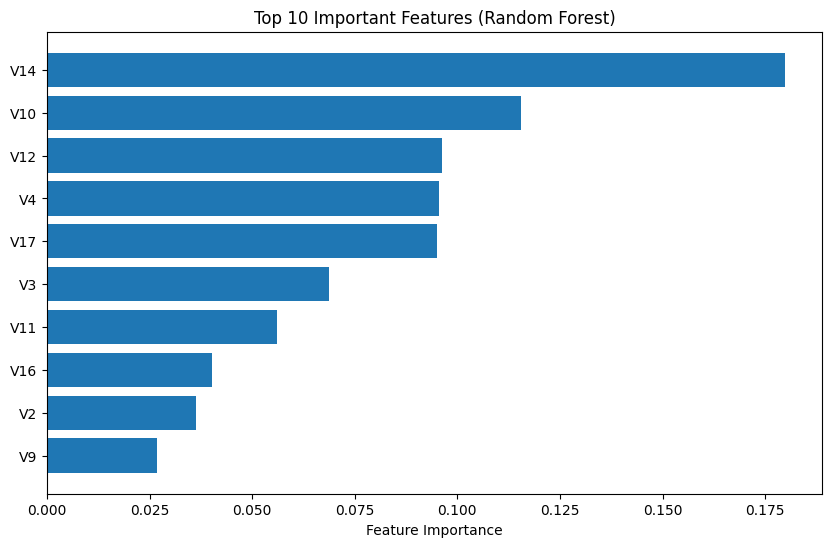


All models saved successfully!
- DNN saved as 'fraud_dnn.h5'
- Random Forest saved as 'rf_baseline.pkl'
- Scaler saved as 'scaler.pkl'


In [12]:
# Feature Importance (only works if Random Forest was trained)
# 1. First ensure you've trained the Random Forest model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# 2. Now calculate and plot feature importance
importances = rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[np.argsort(importances)[-10:]], align='center')
plt.yticks(range(10), feature_names[np.argsort(importances)[-10:]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

# 3. Save all models
model.save('fraud_dnn.h5')
joblib.dump(rf, 'rf_baseline.pkl') 
joblib.dump(scaler, 'scaler.pkl')

print("\nAll models saved successfully!")
print(f"- DNN saved as 'fraud_dnn.h5'")
print(f"- Random Forest saved as 'rf_baseline.pkl'")
print(f"- Scaler saved as 'scaler.pkl'")